# Exp 016: Analyze Performance in Grammar-Controlled Response Generation
This experiment creates descriptive statistics for the evaluation of different models to solve the problem.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

import sys
sys.path.append("../source")
from evaluation import calculate_distinct_n

[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.56844740.dglandorf...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def get_aggs(results, by=['model', 'num_constraints'], distinct=False):
    distinct = {'responses0': calculate_distinct_n} if distinct else {}
    aggs = results.groupby(by).agg({'num_constraints_sat': ['mean', 'count'],
                                    **distinct,
                                    **{col: ['mean', 'count'] for col in results.columns[9:13]}})
    return aggs

In [11]:
models = ["gpt35", "llama", "llama-decoding", "llama-FT", "llama-FT-decoding", "llama-FT-32"]
res = pd.DataFrame()

for model in models:
    results = pd.read_json(f"../data/task1_test_{model}_eval.json")
    results['model']=model
    results = results[results['responses'].apply(len)>0]
    results['num_constraints'] = results['constraints'].apply(len)
    results['num_constraints_sat'] = results['positive_constraints'].apply(lambda x: np.count_nonzero(x)) / results['num_constraints']
    res = pd.concat([res,  results])

single_constraints = res[res['num_constraints']==1].copy()
single_constraints['constraint'] = single_constraints['constraints'].apply(lambda x: x[0])
single_constraints['responses0'] = single_constraints['responses'].apply(lambda x: x[0])

In [12]:
get_aggs(single_constraints, ["model", "response_hit"])

num_constraints_sat       Appropriateness  \
                                              mean count            mean   
model             response_hit                                             
gpt35             0.0                     0.507586   725        3.638889   
                  1.0                     0.612414   725        3.710526   
llama             0.0                     0.606897   725        3.275862   
                  1.0                     0.615172   725        3.452381   
llama-FT          0.0                     0.644138   725        2.696970   
                  1.0                     0.714483   725        2.775000   
llama-FT-32       0.0                     0.691034   725             NaN   
                  1.0                     0.755862   725             NaN   
llama-FT-decoding 0.0                     0.869565    46             NaN   
                  1.0                     0.825000    40             NaN   
llama-decoding    0.0                     0.835862   725        3.131579   
                  1.0                     0.823448   725        3.147059   

                                     Relevance       Content Richness        \
                               count      mean count             mean count   
model             response_hit                                                
gpt35             0.0             36  3.361111    36         3.166667    36   
                  1.0             38  3.710526    38         3.210526    38   
llama             0.0             29  2.896552    29         2.689655    29   
                  1.0             42  3.142857    42         3.000000    42   
llama-FT          0.0             33  2.454545    33         2.363636    33   
                  1.0             40  2.250000    40         2.425000    40   
llama-FT-32       0.0              0       NaN     0              NaN     0   
                  1.0              0       NaN     0              NaN     0   
llama-FT-decoding 0.0              0       NaN     0              NaN     0   
                  1.0              0       NaN     0              NaN     0   
llama-decoding    0.0             38  2.657895    38         2.552632    38   
                  1.0             34  2.705882    34         2.882353    34   

                               Grammatical Correctness        
                                                  mean count  
model             response_hit                                
gpt35             0.0                         4.944444    36  
                  1.0                         5.000000    38  
llama             0.0                         5.000000    29  
                  1.0                         4.880952    42  
llama-FT          0.0                         4.575758    33  
                  1.0                         4.800000    40  
llama-FT-32       0.0                              NaN     0  
                  1.0                              NaN     0  
llama-FT-decoding 0.0                              NaN     0  
                  1.0                              NaN     0  
llama-decoding    0.0                         4.815789    38  
                  1.0                         4.882353    34

In [13]:
def plot_distinct(single, name):
    x=single['responses0']['calculate_distinct_n']
    y=single['num_constraints_sat']['mean']
    ax = sns.scatterplot(x=x, y=y)
    ax.set_ylabel("Constraint Satisfaction")
    ax.set_xlabel("Distinct-2")
    ax.set_title(f"{name}: Single Constraint Satisfaction and Distinctiveness per Skill")
    for i, txt in enumerate(single.index):
        #ax.annotate(txt, (x.iloc[i], y.iloc[i]))
        pass  
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.axis(xmin=0.,xmax=1., ymin=0.,ymax=1.)
    plt.axvline(x=x.mean(), color='r', linestyle='--', label='Mean')
    plt.show()

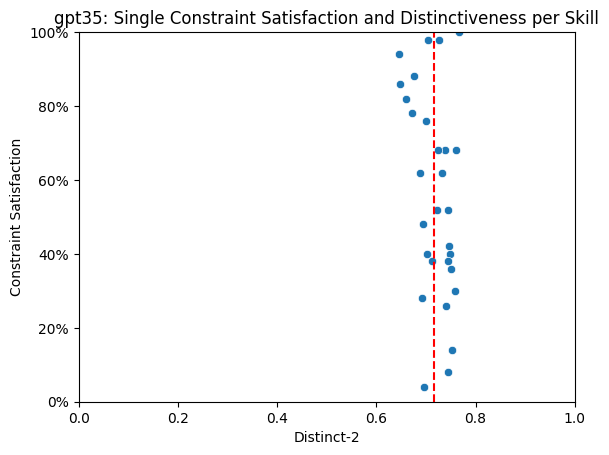

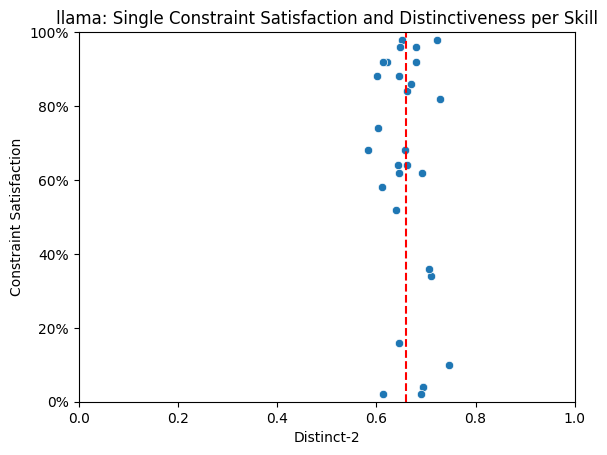

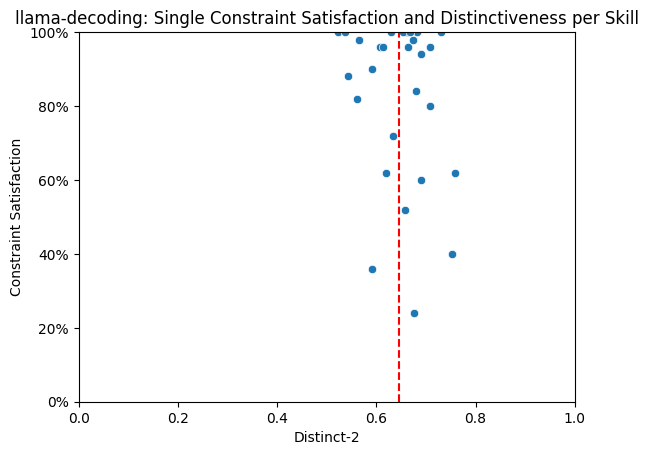

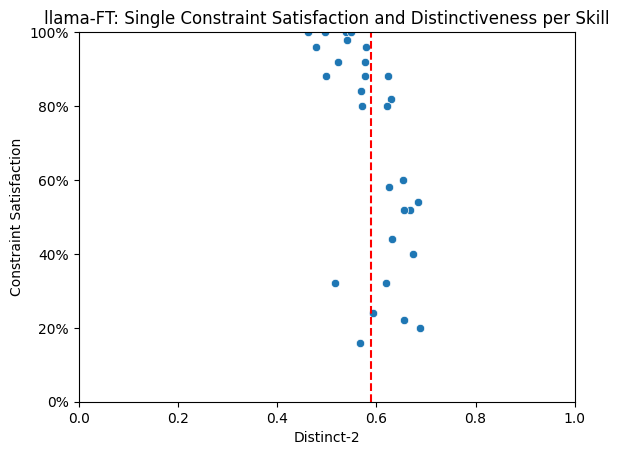

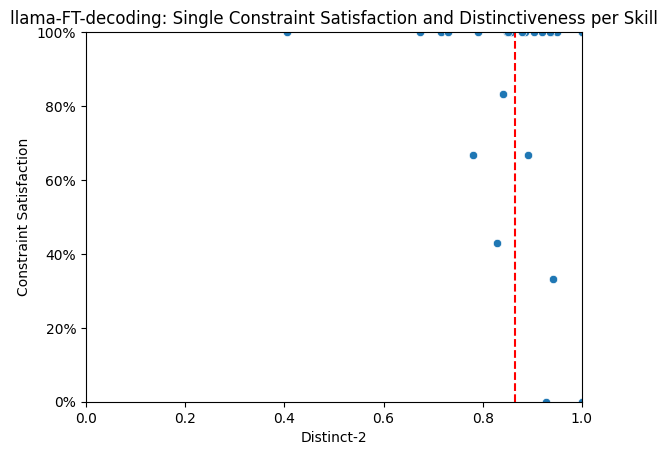

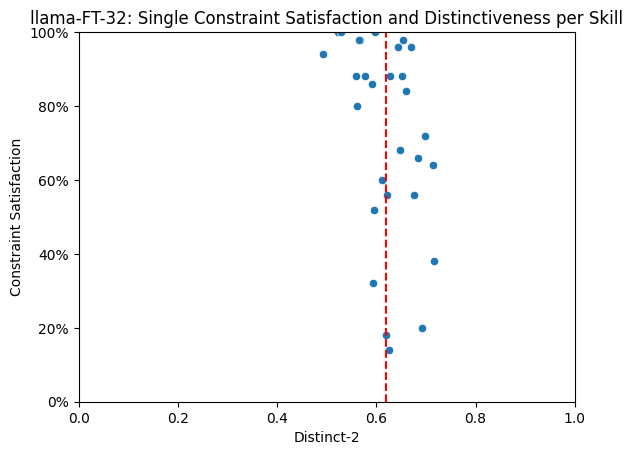

In [14]:
for model in models:
    plot_distinct(get_aggs(single_constraints[single_constraints['model']==model], ["constraint"], distinct=True), name=model)

In [15]:
get_aggs(res, ['model','num_constraints'])

num_constraints_sat       Appropriateness  \
                                                 mean count            mean   
model             num_constraints                                             
gpt35             1                          0.560000  1450        3.675676   
                  2                          0.432500   200        3.166667   
                  3                          0.276667   100        3.714286   
                  4                          0.357500   100        4.000000   
                  6                          0.301667   100        3.333333   
llama             1                          0.611034  1450        3.380282   
                  2                          0.475000   200        3.000000   
                  3                          0.380000   100        3.400000   
                  4                          0.372500   100        2.800000   
                  6                          0.323333   100        3.000000   
llama-FT          1                          0.679310  1450        2.739726   
                  2                          0.435000   200        2.666667   
                  3                          0.343333   100        2.600000   
                  4                          0.285000   100        2.800000   
                  6                          0.228333   100        2.400000   
llama-FT-32       1                          0.723448  1450             NaN   
                  2                          0.410000   200             NaN   
                  3                          0.283333   100             NaN   
                  4                          0.252500   100             NaN   
                  6                          0.206667   100             NaN   
llama-FT-decoding 1                          0.848837    86             NaN   
                  2                          0.388889     9             NaN   
                  3                          0.500000     4             NaN   
                  4                          0.343750     8             NaN   
                  6                          0.333333     5             NaN   
llama-decoding    1                          0.829655  1450        3.138889   
                  2                          0.635000   200        3.666667   
                  3                          0.430000   100        3.166667   
                  4                          0.432500   100        3.272727   
                  6                          0.370000   100        2.800000   

                                        Relevance       Content Richness  \
                                  count      mean count             mean   
model             num_constraints                                          
gpt35             1                  74  3.540541    74         3.189189   
                  2                  12  2.916667    12         2.916667   
                  3                   7  3.428571     7         2.857143   
                  4                   1  4.000000     1         3.000000   
                  6                   6  3.000000     6         3.500000   
llama             1                  71  3.042254    71         2.873239   
                  2                  10  2.400000    10         3.000000   
                  3                   5  3.200000     5         3.200000   
                  4                   5  2.800000     5         2.600000   
                  6                   9  2.777778     9         3.000000   
llama-FT          1                  73  2.342466    73         2.397260   
                  2                  12  2.250000    12         2.416667   
                  3                   5  2.000000     5         2.400000   
                  4                   5  2.000000     5         2.200000   
                  6                   5  2.400000     5         2.200000   
llama-FT-32       1                   0       NaN     0   

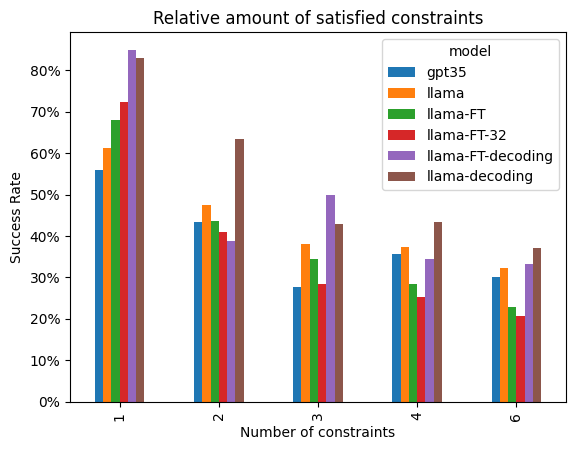

In [16]:
get_aggs(res).unstack(level=0)['num_constraints_sat']['mean'].plot(kind='bar')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel("Success Rate")
plt.xlabel("Number of constraints")
plt.title("Relative amount of satisfied constraints")
plt.show()

In [26]:
get_aggs(res, ["model", "n_subcats"])

num_constraints_sat       Appropriateness        \
                                        mean count            mean count   
model          n_subcats                                                   
gpt35          1                    0.553871  1550        3.666667    78   
               2                    0.378750   200        3.111111     9   
               3                    0.289167   200        3.538462    13   
llama          1                    0.603871  1550        3.364865    74   
               2                    0.411250   200        2.916667    12   
               3                    0.351667   200        3.142857    14   
llama-FT       1                    0.663871  1550        2.762500    80   
               2                    0.357500   200        2.500000    10   
               3                    0.285833   200        2.500000    10   
llama-decoding 1                    0.819677  1550        3.162162    74   
               2                    0.513750   200        3.333333    15   
               3                    0.400000   200        3.000000    11   

                         Relevance       Content Richness        \
                              mean count             mean count   
model          n_subcats                                          
gpt35          1          3.500000    78         3.192308    78   
               2          3.111111     9         2.777778     9   
               3          3.230769    13         3.153846    13   
llama          1          3.000000    74         2.878378    74   
               2          2.666667    12         2.833333    12   
               3          2.928571    14         3.071429    14   
llama-FT       1          2.350000    80         2.412500    80   
               2          2.000000    10         2.200000    10   
               3          2.200000    10         2.300000    10   
llama-decoding 1          2.716216    74         2.729730    74   
               2          2.933333    15         3.200000    15   
               3          2.727273    11         3.363636    11   

                         Grammatical Correctness        
                                            mean count  
model          n_subcats                                
gpt35          1                        4.974359    78  
               2                        4.777778     9  
               3                        4.923077    13  
llama          1                        4.932432    74  
               2                        4.916667    12  
               3                        4.714286    14  
llama-FT       1                        4.712500    80  
               2                        4.600000    10  
               3                        4.700000    10  
llama-decoding 1                        4.851351    74  
               2                        4.800000    15  
               3                        4.818182    11

In [29]:
get_aggs(res, ["model", "n_subcats","num_constraints"])

num_constraints_sat        \
                                                        mean count   
model          n_subcats num_constraints                             
gpt35          1         1                          0.560000  1450   
                         2                          0.465000   100   
               2         2                          0.400000   100   
                         4                          0.357500   100   
               3         3                          0.276667   100   
                         6                          0.301667   100   
llama          1         1                          0.611034  1450   
                         2                          0.500000   100   
               2         2                          0.450000   100   
                         4                          0.372500   100   
               3         3                          0.380000   100   
                         6                          0.323333   100   
llama-FT       1         1                          0.679310  1450   
                         2                          0.440000   100   
               2         2                          0.430000   100   
                         4                          0.285000   100   
               3         3                          0.343333   100   
                         6                          0.228333   100   
llama-decoding 1         1                          0.829655  1450   
                         2                          0.675000   100   
               2         2                          0.595000   100   
                         4                          0.432500   100   
               3         3                          0.430000   100   
                         6                          0.370000   100   

                                         Appropriateness       Relevance  \
                                                    mean count      mean   
model          n_subcats num_constraints                                   
gpt35          1         1                      3.675676    74  3.540541   
                         2                      3.500000     4  2.750000   
               2         2                      3.000000     8  3.000000   
                         4                      4.000000     1  4.000000   
               3         3                      3.714286     7  3.428571   
                         6                      3.333333     6  3.000000   
llama          1         1                      3.380282    71  3.042254   
                         2                      3.000000     3  2.000000   
               2         2                      3.000000     7  2.571429   
                         4                      2.800000     5  2.800000   
               3         3                      3.400000     5  3.200000   
                         6                      3.000000     9  2.777778   
llama-FT       1         1                      2.739726    73  2.342466   
                         2                      3.000000     7  2.428571   
               2         2                      2.200000     5  2.000000   
                         4                      2.800000     5  2.000000   
               3         3                      2.600000     5  2.000000   
                         6                      2.400000     5  2.400000   
llama-decoding 1         1                      3.138889    72  2.680556   
                         2                      4.000000     2  4.000000   
               2         2                      3.500000     4  2.750000   
                         4                      3.272727    11  3.000000   
               3         3                      3.166667     6  3.000000   
                         6                      2.800000     5  2.400000   

                                               Content Richness        \
                        

In [65]:
input_file = "task2_test_gpt35_eval.json"
results = pd.read_json(f"../data/{input_file}")
results['num_categories'] = results['categories'].apply(len)
#results['num_constraints_sat'] = results['positive_constraints'].apply(lambda x: np.count_nonzero(x)) / results['num_constraints']

In [63]:
def categories_satisfied(row):
    df = pd.DataFrame({'score': row['positive_constraints'], 'category': row['positive_categories']})
    return np.mean(df.groupby("category").agg({"score": lambda x: np.count_nonzero(x)})['score'])

In [69]:
results['num_constraints_sat'] = results.apply(categories_satisfied, axis=1)

In [70]:
per_num_constraints = get_aggs(results, 'num_categories')

/tmp/ipykernel_15015/332648669.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


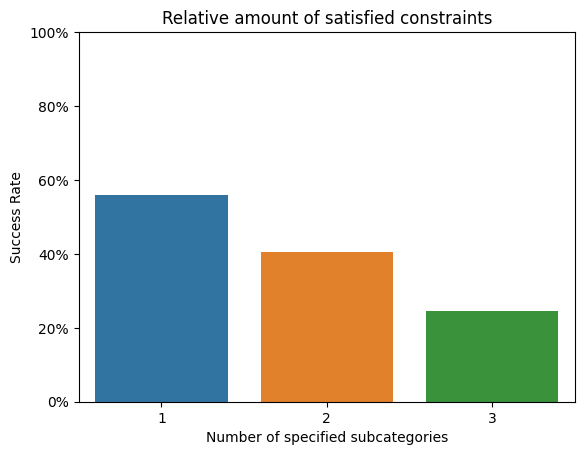

In [72]:
sns.barplot(per_num_constraints, x=per_num_constraints.index, y=per_num_constraints['num_constraints_sat']['mean'])
plt.ylim(0.0,1.0)
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
plt.ylabel("Success Rate")
plt.xlabel("Number of specified subcategories")
plt.title("Relative amount of satisfied constraints")
plt.show()

In [73]:
per_num_constraints

num_constraints_sat Appropriateness       Relevance        \
                              mean            mean count      mean count   
num_categories                                                             
1                         0.560000            3.38   100      2.98   100   
2                         0.403750            3.37   100      2.95   100   
3                         0.244167            3.31   100      2.88   100   

               Content Richness       Grammatical Correctness        
                           mean count                    mean count  
num_categories                                                       
1                          2.82   100                    4.90   100  
2                          2.93   100                    4.88   100  
3                          2.87   100                    4.90   100